# Vector Search with SAM3 + Background Removal (Gaussian Noise) + DINOv3

This notebook implements a vector search pipeline using SAM3 for clothing segmentation, removes the background by replacing it with Gaussian noise, and then uses DINOv3 for embedding generation.

In [1]:
import os
import sys
from sam3.model_builder import build_sam3_image_model
from sam3_utils import CustomSam3Processor  # 배치 지원 프로세서
from transformers import AutoImageProcessor, AutoModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# BPE 경로 설정
bpe_path = os.path.join("assets", "bpe_simple_vocab_16e6.txt.gz")
if not os.path.exists(bpe_path):
    bpe_path_alt = os.path.join(os.getcwd(), "sam3", "assets", "bpe_simple_vocab_16e6.txt.gz")
    if os.path.exists(bpe_path_alt):
        bpe_path = bpe_path_alt
if not os.path.exists(bpe_path):
    raise FileNotFoundError(f"BPE not found: {bpe_path}")

print(f"Using BPE path: {bpe_path}")

# SAM3
sam3_model = build_sam3_image_model(bpe_path=bpe_path).to(device)
sam3_processor = CustomSam3Processor(sam3_model, confidence_threshold=0.3)

# DINOv3
dino_id = "facebook/dinov3-vitb16-pretrain-lvd1689m"
dino_processor = AutoImageProcessor.from_pretrained(dino_id)
dino_model = AutoModel.from_pretrained(dino_id).to(device)
dino_model.eval()

Using device: cuda
Using BPE path: assets/bpe_simple_vocab_16e6.txt.gz


Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

DINOv3ViTModel(
  (embeddings): DINOv3ViTEmbeddings(
    (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (rope_embeddings): DINOv3ViTRopePositionEmbedding()
  (layer): ModuleList(
    (0-11): 12 x DINOv3ViTLayer(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): DINOv3ViTAttention(
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (o_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (layer_scale1): DINOv3ViTLayerScale()
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): DINOv3ViTMLP(
        (up_proj): Linear(in_features=768, out_features=3072, bias=True)
        (down_proj): Linear(in_features=3072, out_features=768, bias=True)
        (act_fn): GELUActivation()
 

In [2]:
stats = {"no_mask": 0, "no_crop": 0}

def l2_normalize(x: torch.Tensor) -> torch.Tensor:
    return x / (x.norm(dim=-1, keepdim=True) + 1e-12)

def segment_clothes(image: Image.Image, prompt: str = "clothing"):
    # SAM3 processor usage in sam3 package is different from transformers
    inference_state = sam3_processor.set_image(image)
    out = sam3_processor.set_text_prompt(state=inference_state, prompt=prompt)
    
    masks = out["masks"]
    scores = out["scores"]

    if masks is None or len(masks) == 0:
        return None

    masks = masks.to(device)
    scores = scores.to(device)

    # Filter by score
    keep = scores > 0.3
    if keep.any():
        sel_masks = masks[keep]
    else:
        idx = torch.argmax(scores)
        sel_masks = masks[idx : idx + 1]

    # Merge masks
    merged = sel_masks.any(dim=0).float()
    merged = merged.cpu().numpy()
    
    if merged.ndim == 3 and merged.shape[0] == 1:
        merged = merged.squeeze(0)
        
    return merged

def apply_mask_with_noise(image: Image.Image, mask: np.ndarray):
    # Create Gaussian noise background
    img_arr = np.array(image)
    noise = np.random.normal(loc=128, scale=30, size=img_arr.shape).astype(np.uint8)
    
    # Ensure mask is the same size as image
    if mask.shape != img_arr.shape[:2]:
        # Resize mask if needed (though typically they should match)
        # For simplicity assuming they match or handled before
        pass
        
    # Expand mask to 3 channels
    mask_3d = np.stack([mask] * 3, axis=-1)
    
    # Combine: keep original where mask is 1, noise where mask is 0
    # Using 0.5 as threshold for binary mask
    binary_mask = mask_3d > 0.5
    
    result_arr = np.where(binary_mask, img_arr, noise)
    return Image.fromarray(result_arr)

def crop_by_mask(image: Image.Image, mask: np.ndarray, pad: int = 4):
    y_indices, x_indices = np.where(mask > 0.5)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return None

    x1, x2 = x_indices.min(), x_indices.max()
    y1, y2 = y_indices.min(), y_indices.max()

    x1 = max(x1 - pad, 0)
    y1 = max(y1 - pad, 0)
    x2 = min(x2 + pad, image.width - 1)
    y2 = min(y2 + pad, image.height - 1)

    return image.crop((x1, y1, x2 + 1, y2 + 1))


def clothes_embedding(image_path: str, prompt: str = "clothing",
                      save_debug: bool = False, debug_dir: str = "masked_noise_debug",
                      stats: dict | None = None):
    if stats is None:
        stats = {"no_mask": 0, "no_crop": 0}

    image = Image.open(image_path).convert("RGB")
    mask = segment_clothes(image, prompt=prompt)
    if mask is None:
        stats["no_mask"] += 1
        return None, stats  # 마스크 검출 실패

    masked_image = apply_mask_with_noise(image, mask)

    # 중간 결과 저장
    if save_debug:
        from pathlib import Path
        os.makedirs(debug_dir, exist_ok=True)
        stem = Path(image_path).stem
        out_path = os.path.join(debug_dir, f"{stem}_masked_noise.jpg")
        masked_image.save(out_path, format="JPEG")

    # Crop the masked image
    crop = crop_by_mask(masked_image, mask)
    if crop is None:
        stats["no_crop"] += 1
        return None, stats  # 크롭 실패

    inputs = dino_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = dino_model(**inputs)
        cls = outputs.last_hidden_state[:, 0]
        emb = l2_normalize(cls)

    return emb.cpu(), stats

In [ ]:
import os
import pickle
from tqdm import tqdm
from PIL import Image
import numpy as np

image_dir = "../data/images_original"
image_files = [
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

vector_store = []
print(f"Indexing {len(image_files)} images (single-image loop)...")
stats = {"no_mask": 0, "no_crop": 0}
for path in tqdm(image_files):
    emb, stats = clothes_embedding(path, stats=stats)
    vector_store.append({"path": path, "embedding": emb})
    print(stats)

print(f"Indexed {len(vector_store)} images.")
output_path = "vector_store_sam3_bg_noise_dino.pkl"
with open(output_path, "wb") as f:
    pickle.dump(vector_store, f)
print(f"Vector store saved to vector_store_sam3_bg_noise_dino.pkl")


Indexing 5762 images (single-image loop)...


  0%|          | 1/5762 [00:01<2:31:32,  1.58s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 2/5762 [00:04<3:42:50,  2.32s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 3/5762 [00:08<4:49:36,  3.02s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 4/5762 [00:08<3:08:05,  1.96s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 5/5762 [00:12<4:07:10,  2.58s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 6/5762 [00:14<4:05:02,  2.55s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 7/5762 [00:18<4:32:42,  2.84s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 8/5762 [00:21<4:50:36,  3.03s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 9/5762 [00:23<4:16:28,  2.67s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 10/5762 [00:26<4:36:09,  2.88s/it]

{'no_mask': 0, 'no_crop': 0}


  0%|          | 11/5762 [00:27<3:19:07,  2.08s/it]

{'no_mask': 1, 'no_crop': 0}


  0%|          | 12/5762 [00:30<3:42:45,  2.32s/it]

{'no_mask': 1, 'no_crop': 0}


  0%|          | 13/5762 [00:33<4:13:08,  2.64s/it]

{'no_mask': 1, 'no_crop': 0}


  0%|          | 14/5762 [00:33<3:11:59,  2.00s/it]

{'no_mask': 1, 'no_crop': 0}


  0%|          | 15/5762 [00:37<3:47:24,  2.37s/it]

{'no_mask': 1, 'no_crop': 0}


  0%|          | 16/5762 [00:41<4:30:56,  2.83s/it]

{'no_mask': 1, 'no_crop': 0}


  0%|          | 17/5762 [00:44<4:46:05,  2.99s/it]

{'no_mask': 1, 'no_crop': 0}


  0%|          | 18/5762 [00:48<5:06:50,  3.21s/it]

{'no_mask': 1, 'no_crop': 0}


  0%|          | 19/5762 [00:48<3:44:34,  2.35s/it]

{'no_mask': 2, 'no_crop': 0}


In [ ]:
import pickle

with open("vector_store_sam3_bg_noise_dino.pkl", "rb") as f:
    vector_store = pickle.load(f)

print("Loaded items:", len(vector_store))

# Search Function
def search_similar(query_image_path: str, top_k: int = 5):
    print(f"Processing query image: {query_image_path}")
    query_emb = clothes_embedding(query_image_path, save_debug=False)

    scores = []
    for item in vector_store:
        # Cosine similarity
        sim = torch.nn.functional.cosine_similarity(query_emb, item["embedding"])
        scores.append((sim.item(), item["path"]))
    
    scores.sort(key=lambda x: x[0], reverse=True)
    
    # Visualize
    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))
    
    # Query
    axes[0].imshow(Image.open(query_image_path))
    axes[0].set_title("Query")
    axes[0].axis("off")
    
    for i in range(top_k):
        if i < len(scores):
            score, path = scores[i]
            try:
                axes[i+1].imshow(Image.open(path))
                axes[i+1].set_title(f"Score: {score:.3f}")
                axes[i+1].axis("off")
            except Exception as e:
                print(f"Error loading result image {path}: {e}")
            
    plt.show()

Loaded items: 91


Processing query image: ../sample_images_from_kaggle/6.jpg


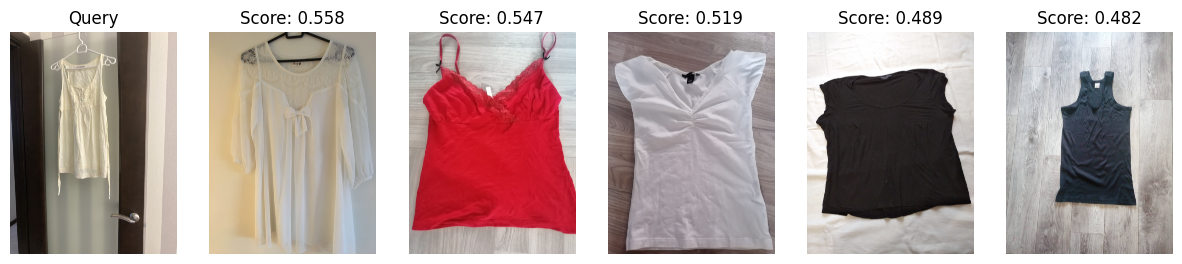

In [ ]:
import os

# Example Search
# Replace with a valid image path from your sample set or a new image
query_image = "../sample_images_from_kaggle/6.jpg"
if os.path.exists(query_image):
    search_similar(query_image)
else:
    print(f"Query image not found: {query_image}")